<div class="alert alert-info" role="alert">
  <hr> <center> <font size="+3.5"> <b> PowerGrid Simulation Use Case - basics </b> </font> </center> <hr>
</div>

<a class="anchor" id="nutshell"></a>


The aim of this notebook is  to introduce the power grid use case in order to:

- familiarize the participants with the use case
- facilitate their comprehension
- provide some tools to vizualize/manipulate the use case data


### Prerequisites

Install the LIPS framework if it is not already done. For more information look at the LIPS framework [Github repository](https://github.com/IRT-SystemX/LIPS) 

#### For developments on local machine

In [ ]:
### Install a virtual environment
# Option 1:  using conda (recommended)
!conda create -n venv_lips python=3.10
!conda activate venv_lips

# Option 2: using virtualenv
!pip install virtualenv
!virtualenv -p /usr/bin/python3.10 venv_lips
!source venv_lips/bin/activate

### Install the LIPS framework
# Option 1: Get the last version of LIPS framework from PyPI (Recommended)
!pip install 'lips-benchmark[recommended]'

# Option 2: Get the last version from github repository
!git clone https://github.com/IRT-SystemX/LIPS.git
!pip install -U LIPS/.[recommended]
#===== 5.16 16:41:02 =====

#### For Google Colab Users
You could also use a GPU device from `Runtime > Change runtime type` and by selecting `T4 GPU`.

In [ ]:
### Install the LIPS framework
# Option 1: Get the last version of LIPS framework from PyPI (Recommended)
!pip install 'lips-benchmark[recommended]'

In [ ]:
# Option 2: Get the last version from github repository
!git clone https://github.com/IRT-SystemX/LIPS.git
!pip install -U LIPS/.[recommended]

Attention: You may restart the session after this installation, in order that the changes be effective.

In [ ]:
# Clone the starting kit
!git clone https://github.com/IRT-SystemX/ml4physim_startingkit_powergrid.git


In [1]:
# and change the directory to the starting kit to be able to run correctly this notebook
import os
os.chdir("ml4physim_startingkit_powergrid")

# Introduction: what is a power grid?


A power grid can be briefly described as a giant network of interconnected parts that deliver electricity from where it's produced (power plants, wind farms, etc.) to where it's used (homes, businesses). 

See the illustrative figure below.

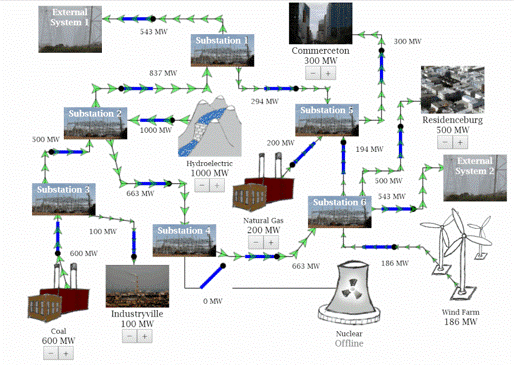




A power grid includes the following typical elements:

- Substations:  A substation is a facility that contains equipment for transforming voltage levels, switching electrical circuits, and regulating voltage. They play a vital role in ensuring efficient and reliable power transmission and distribution.  They have switches that can isolate sections of the grid for maintenance or to prevent cascading outages during faults.

- Buses (or nodes): Buses represent the locations within the power grid where different elements are connected. They could be substations, generators, or even points where multiple transmission lines converge. Buses can be assimilated to a node in a graph; there could be up to 2 nodes per substation.

- Generators: These buses represent power plants, wind farms or photovoltaic or hydraulic generators for example that inject electricity into the grid. The model typically includes details like the active power output, reactive power capability, and voltage regulation limits of these generators.

- Loads: These buses represent locations where electricity is consumed. The model may specify the total amount of power drawn from the grid at these points.

- Transmission Lines: These connect the different buses and allow for the flow of electricity between them. The model typically includes information about the resistance, reactance, and capacity of these lines.

- Transformers: These adjust the voltage levels between different parts of the grid. The model may include details about the voltage transformation ratios and tap settings of these transformers.

The simplified power grid below with 14 substations allows to easily visualize these elements:

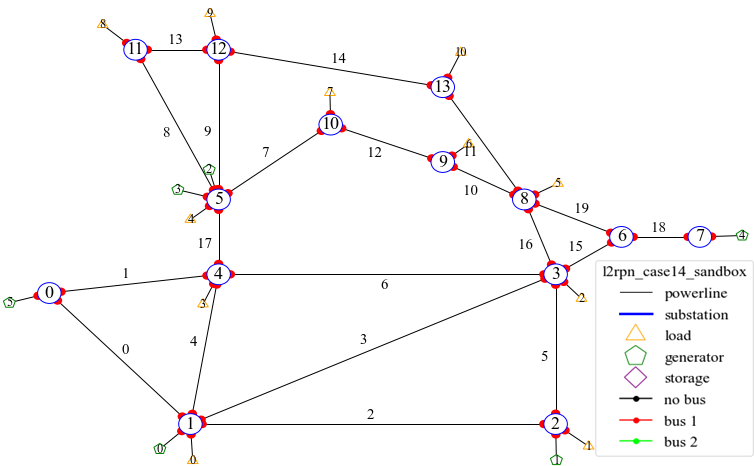

# Problem presentation

Several problems may occur in a power grid. The role of a TSO (Transmission System Operator) is, among others, to ensure at any time the **safety of the power grid**. Operators have to face unexpected events (losing a line for example due to weather constraints) or to anticipate events such as variation of production during the day or as equipment’s maintenance. They do so by assessing the risks, leveraging grid flexibility through simulations and carefully choosing sets of remedial actions which act on the grid topology or on the production levels.


This competition focuses on this particular aspect of **risk assessment in power grids**. The problem is to **anticipate potential threats** on the power grid (several hours ahead to near real-time) and warn the operators accordingly. To do so, current simulators simulate incidents (aka contingencies) involving various elements of the grid (such as the disconnection of a line/production unit), one by one. For each contingency, a risk (weakness of the grid) is detected when overloads are detected by the simulation engine on some lines. On a real grid, this scenario means **running several dozens of thousands of simulations**, thereby, computation time is critical, especially since this risk assessment is refreshed every 15 minutes. 



# Physical simulation overview

## Variables 

So far, in operation, this risk assessment is done through  power flow computation using a physical simulator.

At its core, this simulator:
* take as **input variables**: the amount of **productions** and **loads** in the grid as well as the **topology**,
* compute some necessary physical variables of the grid state that are necessary to assess the security of the grid (**voltages**, **angles**, **active and reactive power**, **intensity** at each node of the grid).

### Usual notations



\begin{array}{l|l}
i & \text{index associated with an individual (entity)} \\
t & \text{index associated with a time instant} \\
k & \text{index associated with a grid node}\\
\ell & \text{index associated with a power line}\\
or & \text{index associated with the "origin" extremity of a power line by convention}\\
ex & \text{index associated with the second extremity of a power line by convention}\\
j & \text{the imaginary part of complex numbers}\\
p_k & \text{active power at node $k$}\\
q_k & \text{reactive power at node $k$}\\
v_k & \text{voltage at node $k$}\\
\theta_k & \text{voltage phase (angle) at node $k$}\\
p^\ell & \text{active power flow over line $l$}\\
q^\ell & \text{reactive power flow over line $l$}\\
a^\ell & \text{current over line $l$}\\
L & \text{number of power lines in the network}\\
K & \text{number of substations in the network}\\
N & \text{number of samples in training set} \\
M & \text{number of samples in test set} \\
\end{array}

## Physical equations

The computation of the grid state involves a set of physical laws such as: 
* Kirchhoff's current law (states that the current flowing into a node must be equal to the current flowing out of it)
* Global energy conservation law (states that the sum of all productions must be equal to the sum of all loads and losses)
* Joule effect  (states that the power of heating generated by an electrical conductor is proportional to the product of its resistance and the square of the current)


More specifically, the physical resolution of the problem is derived from a set of equations that can be described at any node $k$ of the grid as follows.

For a given line $\ell$, the active and reactive ${p}^{\ell}$ and ${q}^{\ell}$ are defined by the Ohm law equations:

${p}^{\ell}_{or} = {|v^{\ell}_{or}|} {|v^{\ell}_{ex}|} (g^{\ell}\cdot \cos ({\theta^{\ell}_{or}} - {\theta^{\ell}_{ex}}) + b^{\ell} \sin ({\theta^{\ell}_{or}} - {\theta^{\ell}_{ex}}))$

${q}^{\ell}_{or} = {|v^{\ell}_{or}|} {|v^{\ell}_{ex}|} (g^{\ell}\cdot \sin ({\theta^{\ell}_{or}} - {\theta^{\ell}_{ex}}) - b^{\ell} \cos ({\theta^{\ell}_{or}} - {\theta^{\ell}_{ex}}))$


The  injected power at a node (productions minus loads) of the network $s_k$ is the sum of active ($p_k$) and reactive powers ($q_k$): $s_k = p_k + q_k$.·

The Kirchhoff energy conservation laws  states that at a node $k$ input power equals to output  power, meaning that the injected power shall be balanced by power flows.



\begin{array}{lll}
0 = -&{p_k} + \sum_{s=1}^K {p}^{\ell}_{k} & \text{Active power}\\
0 = &{q_k} + \sum_{s=1}^K {q}^{\ell}_{k}& \text{Reactive power}
\end{array}

Together with the Ohm law, the relation between voltage angle and magnitude can be formulated for node $k$ and neighboring nodes $s$ as the following equations system to solve:

\begin{array}{lll}
0 = -&{p_k} + \sum_{s=1}^K {|v_k|} {|v_s|} (g_{k,s}\cdot \cos ({\theta_k} - {\theta_s}) + b_{k,s} \sin ({\theta_k} - {\theta_s})) & \text{Active power} \\
0 = &{q_k} + \sum_{s=1}^K {|v_k|} {|v_s|} (g_{k,s}\cdot \sin ({\theta_k} - {\theta_s}) - b_{k,s} \cos ({\theta_k} - {\theta_s})) & \text{Reactive power}
\end{array}

The problem provided in the equation above has the following types of variables:
* ${\theta_j}$ are unknown for all node $j$ (NB. To be completely exhaustive at one node $j$ called the *slack*, $\theta_j$ is known, and often fixed at $0$.)

* ${|v_j|}$ and ${q_j}$ are either known input at any given node $j$ %and unknown for some others. At each nodes $j$, at least $|v_j|$ or $q_j$ is known

* {$p_j$} is a known input and $g_{j,j'}$,  $b_{j,j'}$ known line characteristics for all node $j$ (NB. Here again to be completely exhaustive, for the "slack", $p_j$ is unknown and can be adjusted by the algorithm.)


The global conservation law states the following:

$Prod - Load =  (\sum_{\ell=1}^L (\hat{p}^{\ell}_{ex} + \hat{p}^{\ell}_{or}))$



This problem is **non linear** and **non convex**. To estimate these variables, a power flow solver such as the open-source package [**LightSim2grid**](https://github.com/BDonnot/lightsim2grid) can be used. From these variables that are given by the simulators, it is then possible to derive other types of variables, such as the active and reactive power or the current flowing on all of the powerlines. 

The value of the current on a line $l$ can then be derived from the active and reactive power flows using the following formula: 


$ a^\ell = \frac{\sqrt{obs.p_{or}^2 + obs.q_{or}^2}}{\sqrt{3} \cdot obs.v_{or}} \cdot 1000$ (with the following units: $a^l$ in Amperes, $v_{or}$ in kV, $p_{or}$ in MW, $q_{or}$ in MVar

This variable $a^\ell$  characterizes how loaded is a line.


## Limitations of physical simulators and motivations for ML surrogate models
Today, the computation time for one single timestamp simulation on the French grid takes about 100ms. In practice, for near to real-time operations, in order to assess the security of the grid, we have to compute predictions over a short-time horizon refreshed 15 minutes for the next 24 timestamps (one timestamp per hour of the day)
including possible defects on each node of the grid (about 10000 for the French grid). To face uncertainties induced by the energy transition, the time resolution of simulations will increase even more (for example every 5 minutes).
In this context, the computation time of physical solvers becomes an obstacle as it prevents from exploring as much possible solutions as we would like to.


# Dataset presentation


The dataset we use for this competition is a **118-bus power grid** as described in the literature. (see this [link,https://icseg.iti.illinois.edu/ieee-118-bus-system/] for reference). The IEEE 118-bus power grid is a standard reference system commonly used for research in power systems engineering. It's not a representation of any real-world power grid, but rather a  simplified model with  118 nodes (representing locations like power plants and substations) and  connections between them. 


For this power grid, different reference topologies exist as in real-life. The base one is the fully-meshed one with all lines connected to their bus 1. 
Other reference topologies here differ by topological changes at one or two substations. 

In the case of ensuring the grid safety and in particular avoid overloads of lines, operators usually simulates what is called **N-1** simulations in which 
the failure of one single piece of equipment of the grid (for ex. a generator or a power line) is systematically simulated one at a time.

Similarly, to cope with rare events, operators also conduct what are known as **N-2** simultions. In these simulations,
 the simultaneous failure of a two pieces of equipments within the grid, such as a generator or a power line, are systematically simulated.
    
In the dataset, we will consider:
    - in the training and evaluation dataset, N-1 (only line disconnections) will be considered for some reference topologies 
    - in addition, an additional evaluation dataset will study N-2 (simultaneous 2-line disconnections) in order to assess the generalization capabilities of the provided model


The code below gives a high level overview of this data and shows the important physical components and variables. More details about the dataset are available in the notebook `2_Datasets.ipynb`.

# Input data for Simulation 
**A voir avec visu LIPS existante aussi, ce qui est le plus ergonomique / direct à montrer**

In [ ]:
!pip install seaborn

In [3]:
import warnings
warnings.filterwarnings('ignore')


import numpy as np, pandas as pd
import grid2op
from grid2op.Parameters import Parameters

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(25,8.27)})
from grid2op.PlotGrid import PlotMatplot

## Types and localization of productions and load on the grid
On a power grid, productions and loads are localized at different places. Different types of productions exist, such as renewables and non-renewables. Different kinds of consumers also exist in real-life with different consumption patterns. In this dataset, loads however are based on similar consumption patterns, so no categorization is made here as opposed to productions. 

In [4]:

params = Parameters()

params.MAX_SUB_CHANGED=3

params.MAX_LINE_STATUS_CHANGED=3

In [ ]:

env = grid2op.make("l2rpn_idf_2023")

plot_helper = PlotMatplot(env.observation_space) 

_ = plot_helper.plot_gen_type()
print(env.observation_space)

## Productions and load values on a grid state observation
Productions generates active power P in MW while loads consumes active power in the form of electricity. 
Note that they also produce and consume reactive power Q in alternative currents.Some productions also have to follow a voltage setpoint (PV node).


In [ ]:

obs=env.reset()


_ = plot_helper.plot_info(load_values=obs.load_p.astype("int"),gen_values=np.round(obs.prod_p).astype("int"))

## Different reference topologies

In the dataset, different reference topologies exist as in real-life. The base one is the fully-meshed one with all lines connected to their bus 1. Other reference topologies here differ by topological changes at one or two substations. Zoom on area that includes substations 48 and 68 for instance here where topological changes have been applied. See different buses (nodes) colors for line extremities depending if a line is connected on bus 1 or bus 2. 


In [7]:
# install image io and plotly libraries
!pip install imageio
!pip install plotly
!pip install nbformat

In [ ]:


from grid2op.PlotGrid.PlotPlotly import PlotPlotly 
plot_helper_ly = PlotPlotly(env.observation_space) 


Action1=env.action_space({'set_bus':{'substations_id':[(48,(1,1,1,1,1,1,1,2,2,1,1,2,1,1,1,1,2))]}})#sub48

Action2=env.action_space({'set_bus':{'substations_id':[(68,(1,2,1,1,2,1,2))]}})#sub68
Topo_Action=Action1+Action2

obs_sim, _, _, info = obs.simulate(Topo_Action)

fig = plot_helper_ly.plot_obs(obs_sim,line_info=None, load_info=None, gen_info=None)  

fig.show()
#Zoom on area that includes substations 48 and 68. See different buses (nodes) colors for line extremities depending if

## Line Outages (unexpected disconnections)
In real grids, unexpected line disconnections (aka unplanned outages) can occur. A grid operators need to anticipate the effect of those contingencies and assess which ones might lead to overload that will need to get resolved. Below you can find two simultaneous line disconnections (N-2). In the training set, you will only see single line disconnections (N-1), but you will get evaluated on a out-of-distribution test set that inclueds two simultaneous line disconnections


In [ ]:
#Montrer une topo de référence avec un double changement topo 

Action1=env.action_space({"set_line_status": [(130, -1)]})#from sub 48 -> 46
Action2=env.action_space({"set_line_status": [(184, -1)]})#from sub 68 -> 67
Topo_Action=Action1+Action2
obs_sim, _, _, info = obs.simulate(Topo_Action)
fig = plot_helper_ly.plot_obs(obs_sim,line_info=None, load_info=None, gen_info=None)  
fig.show()
#Zoom on area that includes substations 48 and 68. See different buses (nodes) colors for line extremities depending if

Note that N-2 line disconnections are sampled from the same area in the grid as those are the mutually dependant ones, hence the most interesting to predict in addition to N-1 dline disconnections. See the 3 different grid areas below.

In [ ]:
#plot the areas with lines ids by area
lines_by_area = list(env._game_rules.legal_action.lines_id_by_area.values())

line_color = np.zeros(env.n_line)

for i,line_id_list in enumerate(lines_by_area):
    line_color[line_id_list] = (i+1)
_ = plot_helper.plot_info(line_values=line_color, coloring="line")

An example of OOD data used for this competition

In [14]:
import os
from lips.benchmark.powergridBenchmark import PowerGridBenchmark
from lips.plot.power_grid import PlotData


os.chdir("ml4physim_startingkit_powergrid")
BENCH_CONFIG_PATH = os.path.join("configs", "benchmarks", "lips_idf_2023.ini")
DATA_PATH = os.path.join("input_data_local", "lips_idf_2023")


In [ ]:

benchmark = PowerGridBenchmark(benchmark_path=DATA_PATH,
                               config_path=BENCH_CONFIG_PATH,
                               benchmark_name="Benchmark_competition",
                               load_data_set=True,
                               load_ybus_as_sparse=True)

obs_plotter = PlotData(dataset=benchmark._test_ood_topo_dataset, env_name=benchmark.env_name)
obs_plotter.visualize_obs(id_obs=1000)

# Simulation Output: the power flows 

In the end we are interested to know how loaded are the powerlines, especially if they are overloaded. The line loading is the ratio of the current $ a^l$ over the line thermal limit. We visualize it below and we can see lines overloaded in red.

In [ ]:

fig = plot_helper.plot_obs(obs_sim,line_info="rho", load_info=None, gen_info=None)  
fig.show()
